In [1]:
from houseofreps import *
import numpy as np
import matplotlib.pyplot as plt
import csv 
import os
import pandas
from typing import List, Dict, Tuple


# Representation per citizen of each state

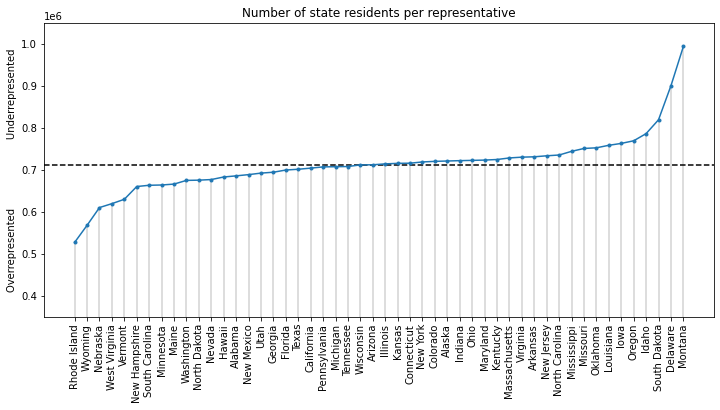

In [68]:
house = HouseOfReps()
year = Year.YR2010
house.reset_pops_assigned_to_true(year, PopType.APPORTIONMENT)

citizens_per_rep = {}
for st, state in house.states.items():
    if st != St.DISTRICT_OF_COLUMBIA:
        citizens_per_rep[st.name] = 1e6 * state.pop_true[year].apportionment / state.no_reps_true[year].voting
        # print(st.name," ",citizens_per_rep)

lists = sorted(citizens_per_rep.items(), key = lambda x: x[1]) # sorted by key, return a list of tuples
xticxs, y = zip(*lists) # unpack a list of pairs into two tuples
x = np.arange(0,len(xticxs))

fair = 1e6 * house.get_total_us_pop_true(year,PopType.APPORTIONMENT) / 435.0

plt.figure(figsize=(12,6))
plt.axhline(fair,linestyle='dashed',color='black')
plt.xticks(x, xticxs, rotation=90)
plt.plot(x, y, '.-')
plt.vlines(x, [0], y, color='lightgray')
plt.ylabel("Overrepresented                      Underrepresented")
plt.ylim(0.35e6,1.05e6)
plt.title('Number of state residents per representative')

plt.subplots_adjust(bottom=0.2)
if not os.path.isdir("figures"):
    os.makedirs('figures')
plt.savefig('figures/no_residents_per_rep.png')

plt.show()

# Calculate how number of reps changes when population is increased, for each state

In [2]:
def write_csv(fname: str, pops_shift_millions: List[float], no_reps_assigned: Dict[St,List[Tuple[float,int,int]]]):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields
        header = ['population shift (millions)']
        for st in no_reps_assigned.keys():
            header.append(st.value + " population (millions)")
            header.append(st.value + " no reps (voting)")
            header.append(st.value + " no reps (nonvoting)")
        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(list(no_reps_assigned.values())[0])):
            row = ["%.8f" % pops_shift_millions[i]]
            for nra in no_reps_assigned.values():
                row.append("%.8f" % nra[i][0]) # population (millions)
                row.append(nra[i][1]) # no voting reps
                row.append(nra[i][2]) # no nonvoting reps
            rows.append(row)

        csvwriter.writerows(rows)

In [5]:
def calculate_no_reps_assigned(house: HouseOfReps, pops_shift_millions: List[float]) -> Dict[St,List[Tuple[float,int,int]]]:
    no_reps_assigned = {}
    for st2 in St:
        no_reps_assigned[st2] = []

    for pop_shift_millions in pops_shift_millions:
        house.reset_pops_assigned_to_true(Year.YR2010, PopType.APPORTIONMENT)
        # try:
        house.shift_pop_from_entire_us_to_state(
            st_to=st, 
            pop_add_millions=pop_shift_millions, 
            verbose=False
            )
        '''
        except:
            # Population of state would be negative
            print("Stopping early - removing: %f people is more than the number of people in the state" % pop_shift_millions)
            break
        '''
        house.assign_house_seats_priority()

        for st2 in St:
            pop = house.states[st2].pop_assigned
            n1 = house.states[st2].no_reps_assigned.voting
            n2 = house.states[st2].no_reps_assigned.nonvoting
            no_reps_assigned[st2].append((pop,n1,n2))
    
    return no_reps_assigned

In [6]:
house = HouseOfReps()

# Population to add to the state, detracted from the rest of the USA
pops_add_millions = list(0.005*np.arange(0,201))

# For exporting data
if not os.path.isdir('analyze_data/population_added_2010'):
    os.makedirs('analyze_data/population_added_2010')

for st in St:
    print("Calculating for: %s" % st)
    
    no_reps_assigned = calculate_no_reps_assigned(house, pops_add_millions)

    # Export data
    write_csv('analyze_data/population_added_2010/%s.csv' % st.value, pops_add_millions, no_reps_assigned)

Calculating for: St.CALIFORNIA
Calculating for: St.TEXAS
Calculating for: St.FLORIDA
Calculating for: St.NEW_YORK
Calculating for: St.PENNSYLVANIA
Calculating for: St.ILLINOIS
Calculating for: St.OHIO
Calculating for: St.GEORGIA
Calculating for: St.NORTH_CAROLINA
Calculating for: St.MICHIGAN
Calculating for: St.NEW_JERSEY
Calculating for: St.VIRGINIA
Calculating for: St.WASHINGTON
Calculating for: St.ARIZONA
Calculating for: St.MASSACHUSETTS
Calculating for: St.TENNESSEE
Calculating for: St.INDIANA
Calculating for: St.MISSOURI
Calculating for: St.MARYLAND
Calculating for: St.WISCONSIN
Calculating for: St.COLORADO
Calculating for: St.MINNESOTA
Calculating for: St.SOUTH_CAROLINA
Calculating for: St.ALABAMA
Calculating for: St.LOUISIANA
Calculating for: St.KENTUCKY
Calculating for: St.OREGON
Calculating for: St.OKLAHOMA
Calculating for: St.CONNECTICUT
Calculating for: St.UTAH
Calculating for: St.IOWA
Calculating for: St.NEVADA
Calculating for: St.ARKANSAS
Calculating for: St.MISSISSIPPI
C

## Similar, but now for losing population

In [7]:
house = HouseOfReps()

# Population to add to the state, detracted from the rest of the USA
pops_lost_millions = list(-0.005*np.arange(0,201))

# For exporting data
if not os.path.isdir('analyze_data/population_lost_2010'):
    os.mkdir('analyze_data/population_lost_2010')

for st in St:
    print("Calculating for: %s" % st)
    
    no_reps_assigned = calculate_no_reps_assigned(house,pops_lost_millions)

    # Export data
    write_csv('analyze_data/population_lost_2010/%s.csv' % st.value, pops_lost_millions, no_reps_assigned)

Calculating for: St.CALIFORNIA
Calculating for: St.TEXAS
Calculating for: St.FLORIDA
Calculating for: St.NEW_YORK
Calculating for: St.PENNSYLVANIA
Calculating for: St.ILLINOIS
Calculating for: St.OHIO
Calculating for: St.GEORGIA
Calculating for: St.NORTH_CAROLINA
Calculating for: St.MICHIGAN
Calculating for: St.NEW_JERSEY
Calculating for: St.VIRGINIA
Calculating for: St.WASHINGTON
Calculating for: St.ARIZONA
Calculating for: St.MASSACHUSETTS


KeyboardInterrupt: 

# Min population shift to get an additional representative

In [79]:
def write_csv_rep(fname: str, header: List[str], min_pop_changes_for_next_rep):
    with open(fname, 'w') as csvfile: 

        # creating a csv writer object 
        csvwriter = csv.writer(csvfile) 
        
        # writing the fields        
        csvwriter.writerow(header) 
            
        # writing the data rows 
        rows = []
        for i in range(0,len(min_pop_changes_for_next_rep)):
            st, min_pop_change_for_next_rep, st_lost, pop_lost = min_pop_changes_for_next_rep[i]
            row = [
                st.name,
                "%.4f" % min_pop_change_for_next_rep,
                st_lost.name,
                "%.4f" % pop_lost
            ]
            rows.append(row)

        csvwriter.writerows(rows)

In [80]:
min_pop_changes_for_next_rep = []
for st in [x for x in St if x != St.DISTRICT_OF_COLUMBIA]:
    # Import data
    fname = 'analyze_data/population_added_2010/%s.csv' % st.value
    df = pandas.read_csv(fname)
    
    pop_shifts_millions = df['population shift (millions)'].to_numpy()
    no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

    ichange = -1
    for i in range(1,len(no_reps_voting)):
        if no_reps_voting[i] != no_reps_voting[0]:
            # Found it
            ichange = i
            break

    if ichange != -1:
        min_pop_change_for_next_rep = pop_shifts_millions[ichange]
    else:
        min_pop_change_for_next_rep = 10000
    
    # Who lost the rep?
    st_lost = None
    for st_2 in St:
        if st_2 == st:
            continue
        no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
        if no_reps_2[0] != no_reps_2[ichange]:
            # This is the one
            if st_lost != None:
                print("ERROR: 2 states lost a rep??? Something went wrong!")
                assert False
            st_lost = st_2
    
    # Population lost in this state
    pop_lost = None
    if st_lost != None:
        pop_lost = df["%s population (millions)" % st_lost.value][0] - df["%s population (millions)" % st_lost.value][ichange]

    min_pop_changes_for_next_rep.append((st,min_pop_change_for_next_rep, st_lost, pop_lost))

# Sort
min_pop_changes_for_next_rep.sort(key = lambda x: x[1])
for x in min_pop_changes_for_next_rep:
    print("%s: min pop change for next rep (millions): %.4f state that lost the rep: %s pop lost: %s" % (x[0], x[1], x[2], x[3]))

header = ['state', 'min. population change for next rep', 'state that lost the rep', 'population this other state lost']
write_csv_rep("analyze_data/one_more_rep.csv", header, min_pop_changes_for_next_rep)

St.MONTANA: min pop change for next rep (millions): 0.0100 state that lost the rep: St.MINNESOTA pop lost: 0.00017212000000021987
St.MISSOURI: min pop change for next rep (millions): 0.0150 state that lost the rep: St.MINNESOTA pop lost: 0.00026244000000019696
St.NORTH_CAROLINA: min pop change for next rep (millions): 0.0200 state that lost the rep: St.MINNESOTA pop lost: 0.00035407000000020616
St.OREGON: min pop change for next rep (millions): 0.0450 state that lost the rep: St.MINNESOTA pop lost: 0.0007817600000006308
St.LOUISIANA: min pop change for next rep (millions): 0.0500 state that lost the rep: St.MINNESOTA pop lost: 0.0008706300000005385
St.NEW_JERSEY: min pop change for next rep (millions): 0.0650 state that lost the rep: St.MINNESOTA pop lost: 0.0011478199999999106
St.NEW_YORK: min pop change for next rep (millions): 0.1050 state that lost the rep: St.MINNESOTA pop lost: 0.001921940000000788
St.DELAWARE: min pop change for next rep (millions): 0.1050 state that lost the re

# Min population shift to lose a representative

In [87]:
min_pop_changes_for_losing_rep = []
for st in St:
    # Import data
    fname = 'analyze_data/population_lost_2010/%s.csv' % st.value
    df = pandas.read_csv(fname)
    
    pop_shifts_millions = df['population shift (millions)'].to_numpy()
    no_reps_voting = df['%s no reps (voting)' % st.value].to_numpy()

    ichange = -1
    for i in range(1,len(no_reps_voting)):
        if no_reps_voting[i] != no_reps_voting[0]:
            # Found it
            ichange = i
            break

    if ichange == -1:
        continue
    min_pop_change_for_losing_rep = pop_shifts_millions[ichange]

    # Who gained the rep?
    st_gained = None
    for st_2 in St:
        if st_2 == st:
            continue
        no_reps_2 = df['%s no reps (voting)' % st_2.value].to_numpy()
        if no_reps_2[0] != no_reps_2[ichange]:
            # This is the one
            if st_gained != None:
                print("ERROR: 2 states gaining a rep??? Something went wrong!")
                assert False
            st_gained = st_2
    
    # Population gained in this state
    pop_gained = None
    if st_gained != None:
        pop_gained = df["%s population (millions)" % st_gained.value][ichange] - df["%s population (millions)" % st_gained.value][0]

    min_pop_changes_for_losing_rep.append((st, min_pop_change_for_losing_rep, st_gained, pop_gained))

# Sort
min_pop_changes_for_losing_rep.sort(key = lambda x: -x[1])
for x in min_pop_changes_for_losing_rep:
    print("%s: min pop change for losing rep (millions): %.4f state that gained the rep: %s pop gained: %s" % (x[0], x[1], x[2], x[3]))

header = ['state', 'min. population change for losing rep', 'state that gained the rep', 'population this other state gained']
write_csv_rep("analyze_data/one_less_rep.csv", header, min_pop_changes_for_losing_rep)